In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# readjust padding
import matplotlib as mpl
mpl.rcParams['savefig.pad_inches'] = 0.2
import seaborn as sns

# custom
from image_generator import plot_sky, show_training_grid, get_waypoints, create_times_array
from utilities import mercator_distance

# skyfield
from skyfield.api import Topos

# Project Overview
---
### Notebooks

1. [Exploratory Data Analysis](../code/1_eda_notebook.ipynb) [This Notebook]
2. [Data Cleaning and preparation](../code/2_data_cleaning_notebook.ipynb) 
3. [Modeling](../code/3_modeling_notebook.ipynb) 

### Scripts
- [image generation](../code/image_generator.py)
- [utility functions](../code/utilities.py)

---


## Exploratory Data Analysis Notebook

---

# Marine Navigation Primer

Marine navigation is an ancient art and science. While GPS technology has allowed for more accurate and reliable navigation, mariners are still trained on the traditional and essential navigational methods. While this project is an exercise in modern deep learning methods applied to marine navigation, traditional navigational techniques are at the heart of the matter and thus some modest explanation of methods is required at the outset. 

### Terrestrial Navigation

Within sight of land, a navigator is able to use some basic mathematics, common sense, and a compass (either a gyro or magnetic) to find their way. 

*Fixes and LOPS*

A mariner ‘fixes’ their position by sighting known, charted objects, and measuring the angle (taking a bearing) from the vessel to the object. This measurement establishes an infinitely long line, called a line of position or L.O.P., with the navigator’s vessel located somewhere on that line. Another measurement taken shortly afterwards of a different object provides an intersection of two L.O.P’s and now the vessel’s position is fixed. This can be repeated an infinite number of times over a variety of time scales. The combination of dead reckoning and diligent and skillful position fixing via LOP’s was the primary navigational method of the world’s seafarers through the late 1980's.

**A 2 LOP Fix for 0835**

![](../md_images/lop_fix.webp)

(Image Credit: Bowditch, N. American Practical Navigator )

*Dead Reckoning*

The most essential terrestrial navigation skill is that of *Dead Reckoning*, where a mariner tracks their course and speed changes as they are made and extrapolates a position. For example a vessel traveling at 20 knots for 12 minutes on a course of $090$ can use the following formula:
$$
\begin{align*}
Distance &= Speed \times Time \\
4nm &= 20kts \times \textrm{.2 hours (12 minutes)}
\end{align*}
$$

To reckon their distance traveled, a course line is drawn from either a known or assumed position on a chart a length of 4 nautical miles, the end of the course and speed vector is the new *Dead Reckoned* position. 


### Celestial Navigation, Traditionally

However, out of sight of land, the L.O.P’s cannot be measured to charted terrestrial objects, so mariners must turn to the lighthouses in the sky, the stars and planets. The principal is exactly the same. The angles are now measured from the visible horizon to the celestial object using a sextant. The angular measurements along with an accurate watch and an astronomical almanac allow the mariner to deduce that their position is somewhere on a large circle of equal altitude. Two celestial observations provide the intersection of two circles of position. The diameter of the circles is such that locally we can imagine their arc as a straight line, and again, the mariner’s position is fixed using a combination of L.O.P.s.

### Celestial Navigation, Currently

The usage of a marine sextant is as much an art as a science and it's utility for modern navigation is obviously limited. Operator skill as well as weather are confounding elements for a reasonably accurate celestial fix, and even if everything is perfect the highest level of accuracy attainable is around 1 nautical mile. Additionally, the time to compute a celestial fix, even with modern computational methods, is still limited by the navigator's ability to take and record their sextant observations. 

Cutting edge modern solutions dispense with the sextant entirely and use a combination of inertial navigation systems and star trackers. This combination is both highly accurate and highly reliable and has been integrated into the navigational packages of modern spacecraft as well as long-range weaponry. This project will instead cast the celestial fix problem as one of deep learning, and endeavor to predict a terrestrial position from an image of the sky with an accompanying time label.  

### Latitude, Longitude, and Circles

A great circle is a circle that lies on the surface of a sphere and passes through the center of the sphere. This circle is equidistant from the center of the sphere at all points along the circumference, making it the largest possible circle that can be drawn on the surface of a sphere. The result is that a great circle is the shortest distance between two points on the surface of the Earth. 

Latitude and Longitude are angular measures along the arcs of great and small circles. Latitude is the angle from the equator to a parallel (a small circle stacked N or S from the equator), measured N or S along the arc of the observers meridian (a great circle running through the planets N/S axis). Longitude is the angle from the prime meridian (one half of a great circle that runs through Greenwich, England) to another meridian measured E or west through 180 along the smaller arc of the equator. 

### Latitude and Longitude of New York Harbor

![](../md_images/AS_LAT_LONG.png)

(Image Credit: Spradling, A. )

It is from the great circle that we arrive at the derivation for the nautical mile: 

$$
\begin{align*}
\textrm{Earth's great circle circumference = 21639 nm} \\
\frac{\textrm{21639 nm}}{\textrm{360 deg}} = \textrm{60 nm/deg}
\end{align*}
$$


---

# I. Voyage Track 

The first step in creating our spatio-temporal training grid is to plot our intended voyage. 

For this voyage we'll make a short voyage off of the coast of San Francisco, from 39 degrees North, 140 degrees West, to 37 degrees North, 138 degrees West a distance of a little over 150 nautical miles. While this voyage is short, and in practice it would not be necessary to compute a full great circle solution, our model does so. 

In order to obtain a full great-circle solution we first establish the distance along the track and the initial heading using the Haversine Formula:

### I. Initial Heading and Overall Distance 
Given two points with latitudes $\phi_1$ and $\phi_2$, and longitudes $\lambda_1$ and $\lambda_2$, the initial course $\theta$ and distance $d$ between the points are given by:

$\theta = \arctan2(\sin(\Delta\lambda)\cos\phi_2, \cos\phi_1\sin\phi_2 - \sin\phi_1\cos\phi_2\cos(\Delta\lambda))$

$d = 2R\arcsin\sqrt{\sin^2(\frac{\phi_2-\phi_1}{2}) + \cos\phi_1\cos\phi_2\sin^2(\frac{\Delta\lambda}{2})}$

where $\Delta\lambda = \lambda_2 - \lambda_1$, $R$ is the radius of the sphere, and $\arctan2(y,x)$ returns the arctangent of $y/x$ taking into account the signs of $y$ and $x$ to determine the correct quadrant.

From the initial course and distance, we then break the great circle track into smaller component parts:

### II. Computing the coordinates of the Vertex

Latitude of the vertex $\phi_v = $

$$
cos \phi_v = \cos \phi_1 \times \sin \theta
$$

Longitude of the vertex $\lambda_v = $ 

$$
\tan \lambda_v = \frac{\tan \phi_2 \times \cos \lambda_1 - \tan \phi_1 \times \cos \lambda_2}{\tan \phi_1 \times \cos \lambda_2 - \tan \phi_2 \times \sin \lambda_1}
$$

### III. Computing Points Along the Track

The great circle track is then broken up into segments of equal angular length and Mercator sailings (rhumb line sailings) are used to determine the course between the waypoints. 

We determine the latitude, $\phi_x$ for each point along the track ($X_1, X_2, \dots$) using:

$$
\sin \phi_x = \sin \phi_v \times \cos D_{v-x}
$$

Where $D_{v-x}$ is the angular distance to the vertex, less the angular distance along the great circle track designated for the waypoints. We then calculate the longitude if each waypoint by:
$$
\sin \Delta \lambda_{v-x} = \frac{\sin D_{v-x}}{\cos L_x}
$$

Number of unique waypoints:  11


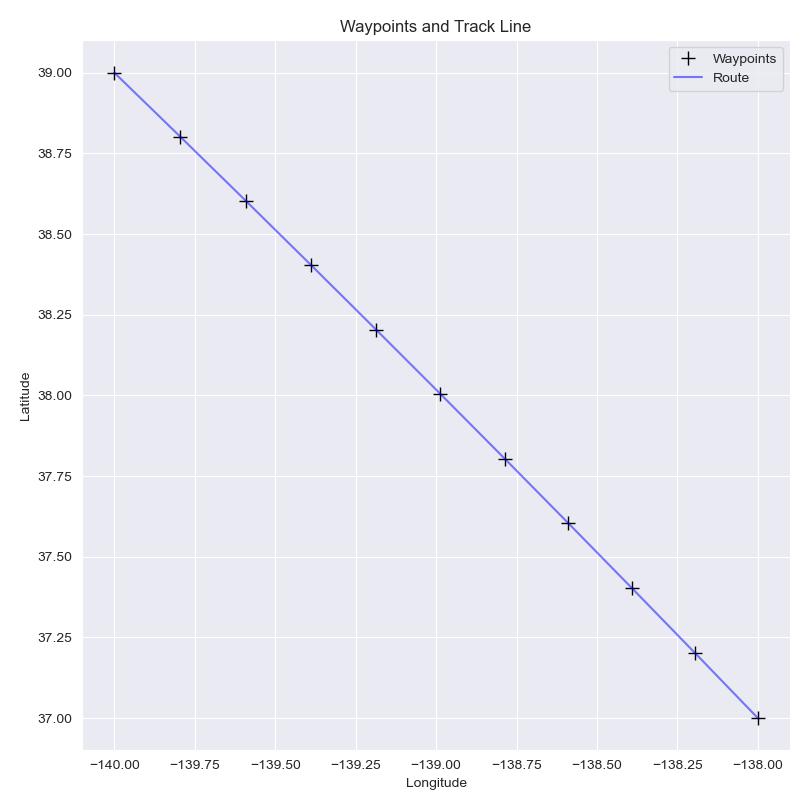

In [21]:
# define starting and ending positions
start = (39, -140)
end = (37, -138)

# get waypoints
waypoints = get_waypoints(start, end, 10, list_of_mile_displacements=[0])

# use seaborn darkgrid
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,8))

# use '+' symbol for waypoints
ax.plot(waypoints[:,1], waypoints[:,0], 'k+', markersize=10, label='Waypoints')
ax.plot(waypoints[:,1], waypoints[:,0], label='Route', color='blue', alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Waypoints and Track Line')
ax.legend()
fig.tight_layout();

Plotted above we see our voyage track line and waypoints along the track. 

#  II. Building the Training Position Arrays

In [24]:
def show_training_grid(start, end, points_along_track=100, displacements=10, displacement_interval=1):

    # get waypoints
    flat_track = get_waypoints(start, end, points_along_track, [x for x in range(0,displacements,displacement_interval)])
     
    # use seaborn darkgrid
    sns.set_style("darkgrid")
    
    # plot points in flat_track
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(flat_track[:, 1], flat_track[:, 0], s=1, c='red')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Training Grid')

    ax.plot(waypoints[:,1], waypoints[:,0], 'k+', markersize=10, label='Waypoints')

    plt.tight_layout()

    # make backround blue
    # ax.set_facecolor('xkcd:light blue')

    # show plot
    plt.show()

# Adding Spatial Dimension

Number of unique waypoints:  1919


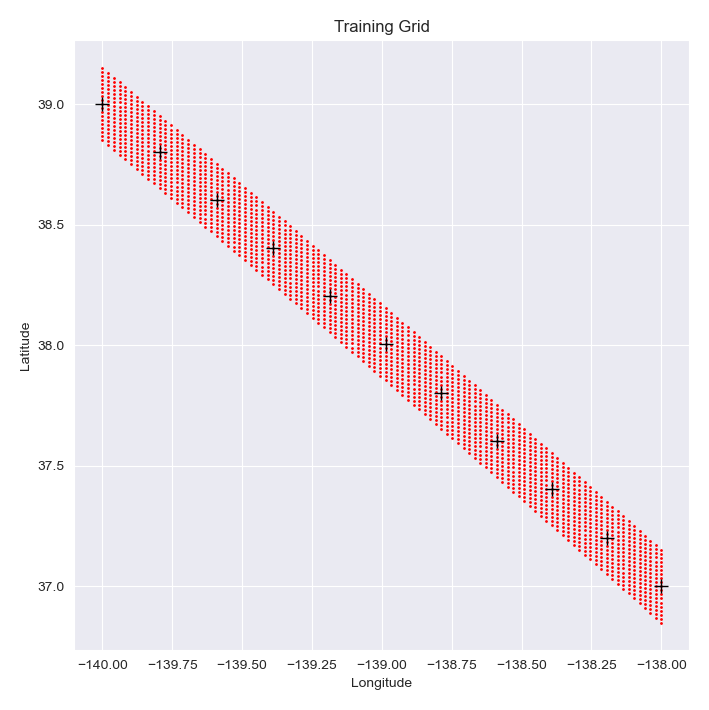

In [25]:
# show training grid
show_training_grid(start=start, end=end, points_along_track=100, displacements=10, displacement_interval=1)

In [26]:
# get waypoints
waypoints = get_waypoints(start, end, 100, list_of_mile_displacements=[0])

# average distance between waypoints
avg_dist = np.mean([mercator_distance(waypoints[i], waypoints[i+1]) for i in range(len(waypoints)-1)])

print(f'Average distance between waypoints: {avg_dist:.2f} miles')

Number of unique waypoints:  101
Average distance between waypoints: 1.53 miles


Our training grid uses our voyage track as a baseline and builds itself out iteratively. Since the model will learn what the sky looks like at a specific position over a series of times, a compromise needs to be made. It isn't practical to learn every position in the world at every time, but it also isn't necessary -- the current grid architecture creates a 10 nm buffer to the North and South of a proposed track line, and it is within these 10 mile buffer areas that the model will have been trained. Should a vessel need to significantly deviate from its planned route, a new series of training images and for the deviation can be created and trained on fairly quickly. 

### Buffer Areas

From the voyage track line, $n$ parallel tracks are displaced to the North and the South by $k$ nautical miles. In the above plot we see 10 tracks displaced by steps of 1 nm to the north and 10 tracks displaced by steps of 1 nm to the South.

Within each track, points along the track are created in alignment with the voyage's needed level of precision. For our purposes, we've create 100 waypoints for each parallel track, giving us a grid that has 1918 unique positions, with a N/S distance between waypoints of 1 NM and an E/W distance between waypoints of approximately 1.53 nautical miles. Should we require greater spatial precision, we would decrease the distance between waypoints in the buffer tracks and decrease the N/S displacement between the buffer tracks. However, as we do this, we greatly increase the size of the training data set. 

# Adding Temporal Dimension

For each position, we then calculate the position of the stars for various increments of time. We do this for all positions in the training grid so that we know what the sky looks like over a designated time period for each position in the grid. 

We can think of the temporal dimension as slices of time that are stacked on each position.

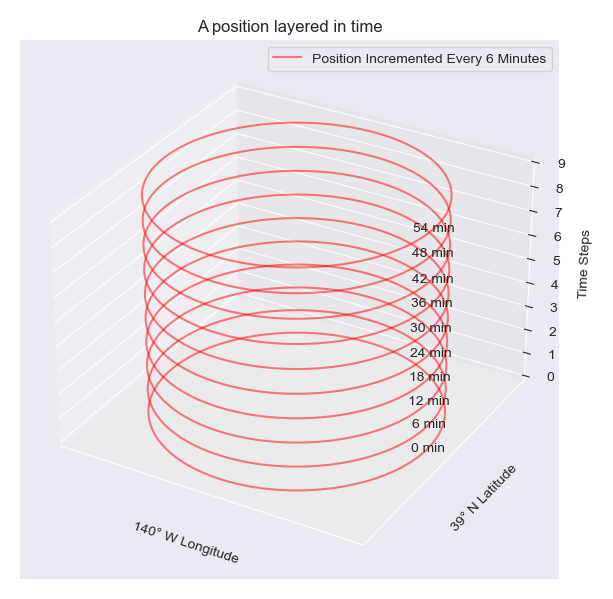

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def spatio_temporal(N=10, r=1, ax=None):
    # use seaborn darkgrid
    sns.set_style("darkgrid")
    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111, projection='3d')
        
    theta = np.linspace(0, 2*np.pi, 100)
    for i in range(N):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        z = np.ones_like(x) * i
        ax.plot(x, y, z, '-r', alpha=0.5)
        
        # plot label of 6 minute intervals, rotate 90 degrees, place at 0,0,0
        ax.text(1, 0, i, f'{i*6} min', rotation=90, horizontalalignment='center', verticalalignment='center')
        plt.legend(['Position Incremented Every 6 Minutes'])
    
    # set labels
    ax.set_xlabel('140° W Longitude')
    ax.set_ylabel('39° N Latitude')
    ax.set_zlabel('Time Steps')
    ax.set_title('A position layered in time')

    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

spatio_temporal()




### Time Increments

Traditionally the position of a ship is fixed at a regular interval that is some increment of 6 minutes, as this allows for the navigator to make rapid and convenient mental speed/time/distance calculations, since 6 minutes is 1/10th of an hour. This shipboard tradition carries over to many other tasks -- log keeping is always done in increments of 6 minutes, rounding up or down as required. 

Thus, for each position in the training grid, we will create an image of the sky for every 6 minutes for a period of 4 hours, a standard navigational watch duration on a merchant vessel at sea. 

In [11]:
# create times array
times = create_times_array(start_time=dt.datetime(2020, 3, 13, 4, 0, 0), end_time=dt.datetime(2020, 3, 13, 8, 0, 0), n=6)

# dataframe of times
times_df = pd.DataFrame()
times_df['time_utc'] = times[1]

times_df.head(10)

,time_utc
0,2020-03-13 04:00:00+00:00
1,2020-03-13 04:06:00+00:00
2,2020-03-13 04:12:00+00:00
3,2020-03-13 04:18:00+00:00
4,2020-03-13 04:24:00+00:00
5,2020-03-13 04:30:00+00:00
6,2020-03-13 04:36:00+00:00
7,2020-03-13 04:42:00+00:00
8,2020-03-13 04:48:00+00:00
9,2020-03-13 04:54:00+00:00


Thus for a 4 hour training window we have 1919 unique positions and 41 times so we will need to produce 78,679 plots for our 4 hour voyage

# III. Synthetic Sky Images For Each Position and Temporal Slice

Now that we've constructed a spaito temporal grid for our voyage, we need to recreate the sky for each position and time slice. 

### Orientation and Projection

We'll use matplotlib and the `Skyfield` library to create the images. 

An assumption for our model is that the camera that is recording the images will be stabilized and maintain a constant alignment, for our purposes, we will image the camera is always oriented to the South and is facing straight up at the observers zenith. 

With this orientation we then build a stereographic projection of the evening sky using `Skyfield`. `Skyfield` handles this process internally, however the underlying process involves projecting points from sphere onto a plane that is tangent to the sphere at a chosen "pole" point. Each point on the sphere is projected onto the plane as a unique point, with the exception of the "pole" point, which maps to infinity. This means that the projection is conformal, meaning that angles are preserved in the projection.

### Ephemerides

In order to plot the stars we need to determine their position on the celestial sphere. For this purpose we need an accurate ephemeris. An ephemeris provides detailed information about the position and motion of celestial objects, in the sky relative to the observer. The standard units of measurement are right ascension and declination, which are equatorial coordinates that describe the object's position with respect to the celestial equator and the position of the observer on the Earth.

Ephemerides are calculated using mathematical models that describe the motion of celestial objects--`Skyfield` uses the DE421 ephemeris published by NASA's Jet Propulsion Labratory. It provides the positions of the Sun, Moon, major planets, and selected minor planets and comets over a time span of about 1600 years, from -1300 to +3000.

With `Skyfield`'s Ephemeris and Stereographic projection functionality, we can easily and rapidly plot the night sky for any position and time we desire. While there are other astronomy packages that offer extremely robust synthetic visualization capabilities--most notably `Stellarium` -- this solution provides for much flexibility and the ability to produce 10's or 100's of thousands of plots for a large and dense spatio-temporal grid with relatively low memory usage, as each image is only 9 kb.



### Image of the Sky for 39° North, 140° West for 0400 UTC 13 March, 2020

Creating sky For : 2020-03-13 04:00:00+00:00 [  39. -140.]


(<Figure size 900x900 with 1 Axes>, <AxesSubplot:>)

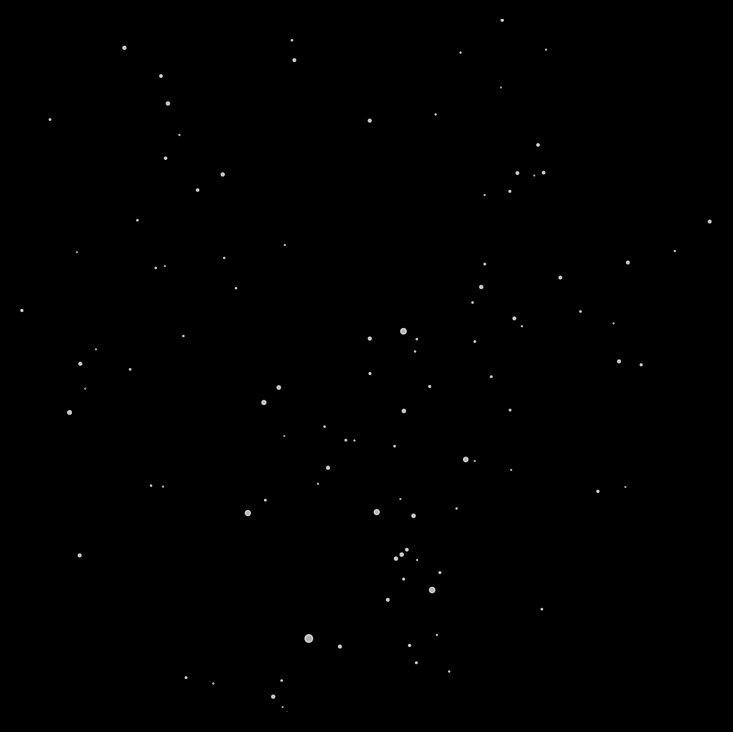

In [12]:
# set dark background
plt.style.use('dark_background')
position = np.array([39.000, -140.000])
observer = Topos(latitude_degrees = position[0], longitude_degrees=position[1])
print('Creating sky For :',times[1][0], position)

# create sky
plot_sky(t = times[0][0], observer = observer, cloud_cover=0/8, save_images=False)

Above we see a synthetic image of the night sky for one of our training positions and times. We chose to use a limiting star magnitude of 3.5, so only the brighter stars in the night sky are visible. 

### Clouds 

The clarity of the night sky is never a given. 

Our night sky plotting function allows for the random placement of clouds according by a specified proportion of cloud cover. While the model trained for this project was trained on images of the sky free of cloud cover, the functionality is there and we leave it as an area of further development. 

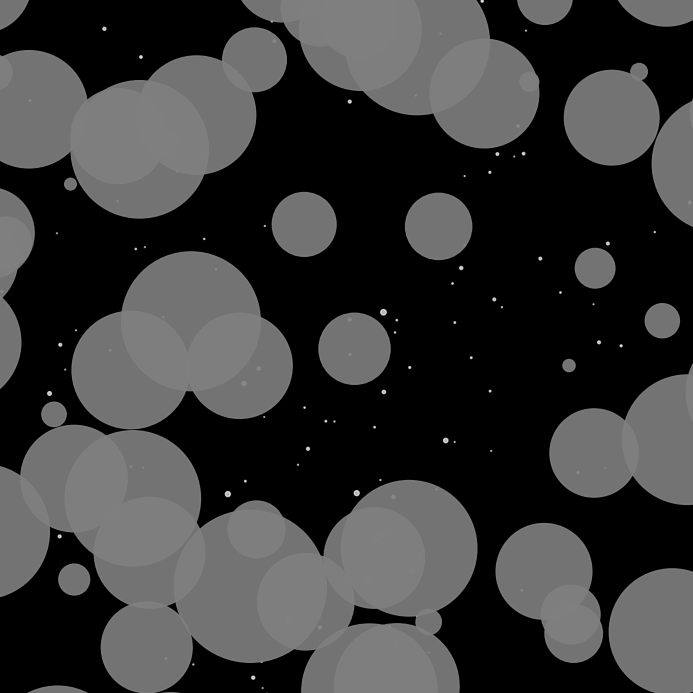

In [9]:
# plot sky with 5/8 cloud cover
plot_sky(t = times[0][0], observer = observer, cloud_cover=5/8, save_images=False);